In [1]:
from __future__ import print_function, division
from builtins import range

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score

sns.set(color_codes=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 80
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 20

In [3]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [4]:
filename = '../large_files/spam.csv'
df = pd.read_csv(filename, encoding='latin-1')
df.columns = ['label', 'text', 'v3', 'v4', 'v5']
df = df.drop(['v3','v4','v5'],axis=1)
df.dropna()
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
def process_label(label):
    if label == 'ham':
        return 1
    else:
        return 2
    
df['label'] = df['label'].apply(process_label)
df.head()

,label,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,2,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [7]:
text = df['text'].copy()
text_feat = text.apply(text_process)

In [8]:
# prepare text samples and their labels
print('Loading in comments...')
sentences = text_feat.values
targets = to_categorical(df["label"].values)


targets

Loading in comments...


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [9]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

sequences[:2]

[[9,
  4243,
  685,
  603,
  570,
  1131,
  38,
  58,
  259,
  1132,
  81,
  2773,
  1133,
  15,
  4244,
  68],
 [10, 220, 1283, 342, 1, 1716]]

In [10]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 80
min sequence length: 0
median sequence length: 7


In [11]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 9431 unique tokens.


In [12]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=111)
y_test_max = np.argmax(y_test, axis=1)
print('Shape of data tensor:', data.shape)
print(y_test_max)

Shape of data tensor: (5572, 80)
[1 1 1 ... 1 1 1]


In [13]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [14]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [15]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(128, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
output = Dense(3, activation="sigmoid")(x)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model = Model(input_, output)
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [17]:
%%time
print('Training model...')
r = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3565 samples, validate on 892 samples
Epoch 1/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.3638 - acc: 0.8614 - val_loss: 0.2617 - val_acc: 0.8655
Epoch 2/20
3565/3565 [==============================] - 5s 1ms/step - loss: 0.1917 - acc: 0.8656 - val_loss: 0.1758 - val_acc: 0.8655
Epoch 3/20
3565/3565 [==============================] - 5s 1ms/step - loss: 0.1514 - acc: 0.8656 - val_loss: 0.1607 - val_acc: 0.8655
Epoch 4/20
3565/3565 [==============================] - 5s 1ms/step - loss: 0.1354 - acc: 0.8656 - val_loss: 0.1579 - val_acc: 0.8655
Epoch 5/20
3565/3565 [==============================] - 5s 1ms/step - loss: 0.1239 - acc: 0.8721 - val_loss: 0.1555 - val_acc: 0.9070
Epoch 6/20
3565/3565 [==============================] - 5s 1ms/step - loss: 0.1249 - acc: 0.9122 - val_loss: 0.1614 - val_acc: 0.9484
Epoch

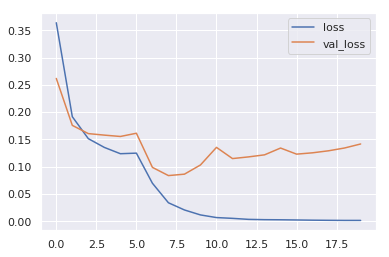

In [18]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

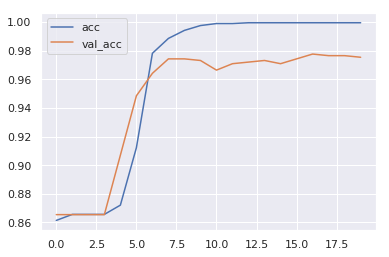

In [19]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [20]:
p = model.predict(X_test)
predicted = np.argmax(p, axis=1)
print('accuracy %s' % accuracy_score(y_test_max, predicted))

accuracy 0.9820627802690582


In [21]:
# create an LSTM network with a Bidirectional LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(3, activation="sigmoid")(x)

In [22]:
model = Model(input_, output)
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [27]:
%%time
print('Training model...')
r = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model...
Train on 3565 samples, validate on 892 samples
Epoch 1/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.0932 - acc: 0.9450 - val_loss: 0.1973 - val_acc: 0.9406
Epoch 2/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.0932 - acc: 0.9495 - val_loss: 0.1996 - val_acc: 0.9439
Epoch 3/20
3565/3565 [==============================] - 7s 2ms/step - loss: 0.0932 - acc: 0.9520 - val_loss: 0.2031 - val_acc: 0.9462
Epoch 4/20
3565/3565 [==============================] - 9s 2ms/step - loss: 0.0932 - acc: 0.9576 - val_loss: 0.2033 - val_acc: 0.9496
Epoch 5/20
3565/3565 [==============================] - 9s 2ms/step - loss: 0.0932 - acc: 0.9599 - val_loss: 0.2062 - val_acc: 0.9529
Epoch 6/20
3565/3565 [==============================] - 9s 2ms/step - loss: 0.0932 - acc: 0.9689 - val_loss: 0.2077 - val_acc: 0.9563
Epoch 7/20
3565/3565 [==============================] - 9s 3ms/step - loss: 0.0931 - acc: 0.9736 - val_loss: 0.2111 - val_acc: 0.96

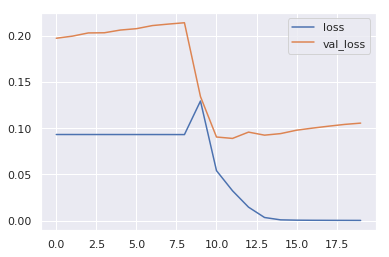

In [28]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

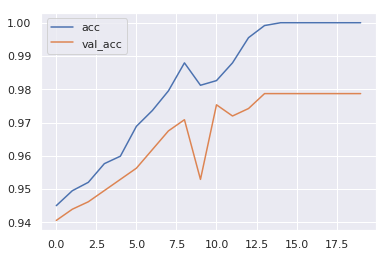

In [29]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [30]:
p = model.predict(X_test)
predicted = np.argmax(p, axis=1)
print('accuracy %s' % accuracy_score(y_test_max, predicted))

accuracy 0.9811659192825112


In [31]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[963   4]
 [ 17 131]]
Normalized confusion matrix
[[1.   0.  ]
 [0.11 0.89]]


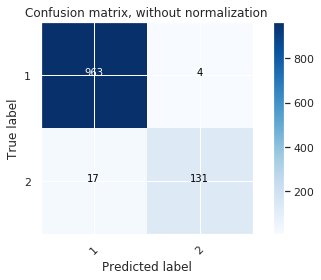

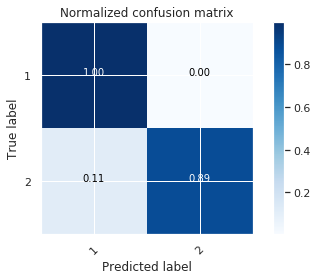

In [36]:
class_names=[1, 2]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, predicted, class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()